In [1]:
import sys
import os

from dotenv import load_dotenv

load_dotenv()

# Add the parent directory (project root) to sys.path
sys.path.append(os.path.abspath('..'))


In [2]:
# automatically load changes from the sandbox_steps module
%load_ext autoreload
%autoreload 2

In [5]:
from llm import GroqModel, OpenAIModel, OpenRouterModel
from tools import MoveTool, BaseTool

In [186]:
import re
from PIL import Image, ImageDraw, ImageFont

def parse_point_json(model_response):
    """
    Parse a single point from a JSON string or dict of the form:
      { "point": { "x": "678", "y": "691" } }

    Args:
        model_response (str or dict): JSON string or already‐decoded dict.

    Returns:
        dict: { 'x': int, 'y': int }

    """

    model_response = model_response.strip("```")
    model_response = model_response.strip("json")
    if isinstance(model_response, str):
        data = json.loads(model_response)
    else:
        data = model_response

    if 'point' not in data or 'x' not in data['point'] or 'y' not in data['point']:
        raise KeyError("Expected format: { 'point': { 'x': ..., 'y': ... } }")

    return {
        'x': int(data['point']['x']),
        'y': int(data['point']['y'])
    }


def draw_point(image_path, point, output_path,
               marker_radius=5, marker_color='red'):
    """
    Draw a circle at the given point and save the image.

    Args:
        image_path (str): Path to the input image.
        point (dict): {'x': int, 'y': int}
        output_path (str): Where to save the annotated image.
        marker_radius (int): Radius of the point marker.
        marker_color (str): Color for the marker and label background.
    """
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()

    x, y = point['x'], point['y']

    # Draw circle marker
    draw.ellipse(
        [(x - marker_radius, y - marker_radius),
         (x + marker_radius, y + marker_radius)],
        outline=marker_color,
        width=2
    )

    # Optionally label the point with its coordinates
    label = f"({x}, {y})"
    bbox = draw.textbbox((0, 0), label, font=font)
    text_w = bbox[2] - bbox[0]
    text_h = bbox[3] - bbox[1]
    text_x = x - text_w // 2
    text_y = y + marker_radius + 2

    draw.rectangle(
        [text_x, text_y, text_x + text_w, text_y + text_h],
        fill=marker_color
    )
    draw.text((text_x, text_y), label, fill='white', font=font)

    img.save(output_path)


In [9]:
llama_model = GroqModel(    
    tools = {
            MoveTool.name: MoveTool(),
            }
)

In [ ]:
messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "https://i.ytimg.com/vi/59IRf44uR1w/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLAgfCAj1lJ6m7sgmzCKFOZfYSbJrQ"
                    }
                },
                {
                    "type": "text",
                    "text": "Use individual boxes to locate the position of each enemy in the image, output all bbox coordinates in JSON format, do not output ```json```. Respond with bboxes only."
                },
            ]
        }
    ]

content, messages, response = llama_model.complete(messages=messages)

ChatCompletion(id='chatcmpl-478ae71f-5811-4411-b2a4-53478b679835', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='[\n  {\n    "bbox": [\n      0.609, 0.512, 0.706,0.803\n    ]\n  },\n  {\n    "bbox": [\n      0.765, 0.539,0.843,0.820\n    ]\n  }\n]', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None))], created=1746699115, model='meta-llama/llama-4-scout-17b-16e-instruct', object='chat.completion', service_tier=None, system_fingerprint='fp_37da608fc1', usage=CompletionUsage(completion_tokens=64, prompt_tokens=1253, total_tokens=1317, completion_tokens_details=None, prompt_tokens_details=None, queue_time=0.7242065470000001, prompt_time=0.057322633, completion_time=0.139148976, total_time=0.196471609), usage_breakdown={'models': None}, x_groq={'id': 'req_01jtqp2nzwfhvbrfe61srpvw8b'})
ChatCompletionMessage(content='[\n  {\n    "bbox": [\n      0.609, 0.512, 0.706,0.803\n    ]\n  },\n  {\n

('[\n  {\n    "bbox": [\n      0.609, 0.512, 0.706,0.803\n    ]\n  },\n  {\n    "bbox": [\n      0.765, 0.539,0.843,0.820\n    ]\n  }\n]',
 [{'role': 'user',
   'content': [{'type': 'image_url',
     'image_url': {'url': 'https://i.ytimg.com/vi/59IRf44uR1w/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLAgfCAj1lJ6m7sgmzCKFOZfYSbJrQ'}},
    {'type': 'text',
     'text': 'Use individual boxes to locate the position of each enemy in the image, output all bbox coordinates in JSON format, do not output ```json```. Respond with bboxes only.'}]}],
 ChatCompletionMessage(content='[\n  {\n    "bbox": [\n      0.609, 0.512, 0.706,0.803\n    ]\n  },\n  {\n    "bbox": [\n      0.765, 0.539,0.843,0.820\n    ]\n  }\n]', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None))

In [ ]:
gpt_model = OpenAIModel(    
    tools = {
            MoveTool.name: MoveTool(),
            }
            )

In [45]:
gpt_model.complete(messages=messages)

ChatCompletionMessage(content='[\n    {\n        "x": 330,\n        "y": 250,\n        "width": 50,\n        "height": 100\n    },\n    {\n        "x": 430,\n        "y": 260,\n        "width": 60,\n        "height": 120\n    }\n]', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None)


('[\n    {\n        "x": 330,\n        "y": 250,\n        "width": 50,\n        "height": 100\n    },\n    {\n        "x": 430,\n        "y": 260,\n        "width": 60,\n        "height": 120\n    }\n]',
 [{'role': 'user',
   'content': [{'type': 'image_url',
     'image_url': {'url': 'https://i.ytimg.com/vi/59IRf44uR1w/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLAgfCAj1lJ6m7sgmzCKFOZfYSbJrQ'}},
    {'type': 'text',
     'text': 'Use individual boxes to locate the position of each enemy in the image, output all bbox coordinates in JSON format, do not output ```json```. Respond with bboxes only.'}]}],
 ChatCompletionMessage(content='[\n    {\n        "x": 330,\n        "y": 250,\n        "width": 50,\n        "height": 100\n    },\n    {\n        "x": 430,\n        "y": 260,\n        "width": 60,\n        "height": 120\n    }\n]', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))

# Open Router - Qwen

In [ ]:
qwen_model_3b = OpenRouterModel(model="qwen/qwen2.5-vl-3b-instruct:free")

In [14]:
qwen_model_3b.complete(messages)

NotFoundError: Error code: 404 - {'error': {'message': 'No endpoints found for qwen/qwen2.5-vl-3b-instruct.', 'code': 404}, 'user_id': 'user_2vZnbzPtrv6khL3CIautgkdVGJa'}

In [216]:
qwen_model_7b = OpenRouterModel(model="qwen/qwen-2.5-vl-7b-instruct")

qwen_model_7b = OpenRouterModel(model="qwen/qwen2.5-vl-32b-instruct")

In [217]:
content, message, response = qwen_model_7b.complete(messages)

ChatCompletion(id='gen-1746703066-HSCFg5lCIe01WgaQjXAD', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```json\n{\n  "point": {\n    "x": "1290",\n    "y": "560"\n  }\n}\n```', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None, reasoning=None), native_finish_reason='stop')], created=1746703066, model='qwen/qwen2.5-vl-32b-instruct', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=33, prompt_tokens=2768, total_tokens=2801, completion_tokens_details=None, prompt_tokens_details=None), provider='Fireworks')
ChatCompletionMessage(content='```json\n{\n  "point": {\n    "x": "1290",\n    "y": "560"\n  }\n}\n```', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None, reasoning=None)


In [218]:
print(content)

```json
{
  "point": {
    "x": "1290",
    "y": "560"
  }
}
```


### Drawing the bboxes

In [219]:
points = parse_point_json(content)
print(type(points))
points

<class 'dict'>


{'x': 1290, 'y': 560}

In [220]:
draw_point("compressed_image.jpg", points, "annotated_image.jpg")


In [80]:
qwen_model_32b = OpenRouterModel(model="qwen/qwen2.5-vl-32b-instruct:free")

In [79]:
qwen_model_32b.complete(messages)

TypeError: 'NoneType' object is not subscriptable

In [86]:
llama_model = OpenRouterModel(model="qwen/qwen2.5-vl-72b-instruct")

ChatCompletion(id='gen-1746669959-mNEzKgIDDVMoS2TNkDTq', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='[\n\t{"bbox_2d": [242, 90, 262, 131], "label": "enemy"}\n]', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None, reasoning=None), native_finish_reason='stop')], created=1746669959, model='qwen/qwen2.5-vl-72b-instruct', object='chat.completion', service_tier=None, system_fingerprint='', usage=CompletionUsage(completion_tokens=35, prompt_tokens=122, total_tokens=157, completion_tokens_details=None, prompt_tokens_details=None), provider='Novita')
ChatCompletionMessage(content='[\n\t{"bbox_2d": [242, 90, 262, 131], "label": "enemy"}\n]', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None, reasoning=None)


('[\n\t{"bbox_2d": [242, 90, 262, 131], "label": "enemy"}\n]',
 [{'role': 'user',
   'content': [{'type': 'image_url',
     'image_url': {'url': ''}},
    {'type': 'text',
     'text': 'Use individual boxes to locate the position of each enemy in the image, output all bbox coordinates in JSON format, do not output ```json```. Respond with bboxes only.'}]}],
 ChatCompletionMessage(content='[\n\t{"bbox_2d": [242, 90, 262, 131], "label": "enemy"}\n]', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None, reasoning=None))
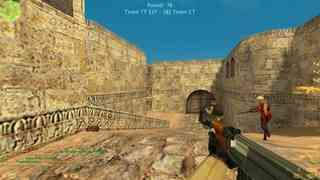

In [87]:
llama_model.complete(messages)

In [159]:
from PIL import Image
import io
import base64
import requests

def download_and_compress_image(url, output_filename="compressed_image.jpg"):
    """
    Downloads an image from a URL, compresses it, saves it to disk,
    sets the byte data to a variable, and returns the Base64 encoded string.

    Args:
        url (str): The image URL to download.
        output_filename (str): Filename to save the compressed image.

    Returns:
        tuple: (base64_encoded_string, image_bytes)
    """
    try:
        # 1. Download the image
        response = requests.get(url)
        response.raise_for_status()
        img_data = response.content

        # 2. Open image
        original_image = Image.open(io.BytesIO(img_data))

        # # 3. Compress it
        # original_width, original_height = original_image.size
        # target_width = 320
        # aspect_ratio = original_height / original_width
        # target_height = int(target_width * aspect_ratio)

        # resized_image = original_image.resize((target_width, target_height), Image.Resampling.LANCZOS)

        resized_image = original_image

        # 4. Save to in-memory buffer as JPEG
        img_byte_arr_io = io.BytesIO()
        resized_image.save(img_byte_arr_io, format='JPEG', quality=30)
        image_bytes = img_byte_arr_io.getvalue()

        # 5. Save to file
        with open(output_filename, 'wb') as f:
            f.write(image_bytes)

        # 6. Encode to Base64
        base64_encoded_string = base64.b64encode(image_bytes).decode('utf-8')

        return base64_encoded_string, image_bytes

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

# Example usage
#image_url = "https://i.ytimg.com/vi/59IRf44uR1w/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLAgfCAj1lJ6m7sgmzCKFOZfYSbJrQ"
image_url = "https://csdownload.net/wp-content/uploads/2025/04/cs-1.6-640x480-resolution-gameplay-screenshot.webp"
image_url = "https://cdn.dbolical.com/videos/mods/1/54/53741/CSCounter-Strike_2025.01.05_-_22.12.40.02.mp4.jpg"
image_url = "https://loadcs.com/images/full/faq_03.jpg"
base64_string, image_bytes = download_and_compress_image(image_url)

if base64_string:
    print("Image downloaded, compressed, and saved successfully.")
    print(f"Base64 (first 100 chars): {base64_string[:100]}...")
else:
    print("Failed to process image.")


Image downloaded, compressed, and saved successfully.
Base64 (first 100 chars): /9j/4AAQSkZJRgABAQAAAQABAAD//gA8Q1JFQVRPUjogZ2QtanBlZyB2MS4wICh1c2luZyBJSkcgSlBFRyB2NjIpLCBxdWFsaXR5...


In [ ]:
messages = [
        
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_string}"
                    }
                },
                {
                    "type": "text",
                    "text": "Locate the middle of the  counter-strike enemy lying on the ground and output the result in XML format as a single point."
                },
            ]
        }
    ]

In [171]:
# structured output to keep it clean
import json 

example2_response = json.dumps(
    {
        "point": {"x": "500", "y": "452"},
    },
    ensure_ascii=False
)

example2_response

'{"point": {"x": "500", "y": "452"}}'

[{'role': 'system',
  'content': 'Locate the nearest standing person from counterstrike gameplay. Locate the exact location of the middle of the body. Output JSON containing the point.\n            Example:\n\n            Q: <provided game play image>\n            A: {"point": {"x": "500", "y": "452"}}'},
 {'role': 'user',
  'content': [{'type': 'image_url',
    'image_url': {'url': ''}}]}]
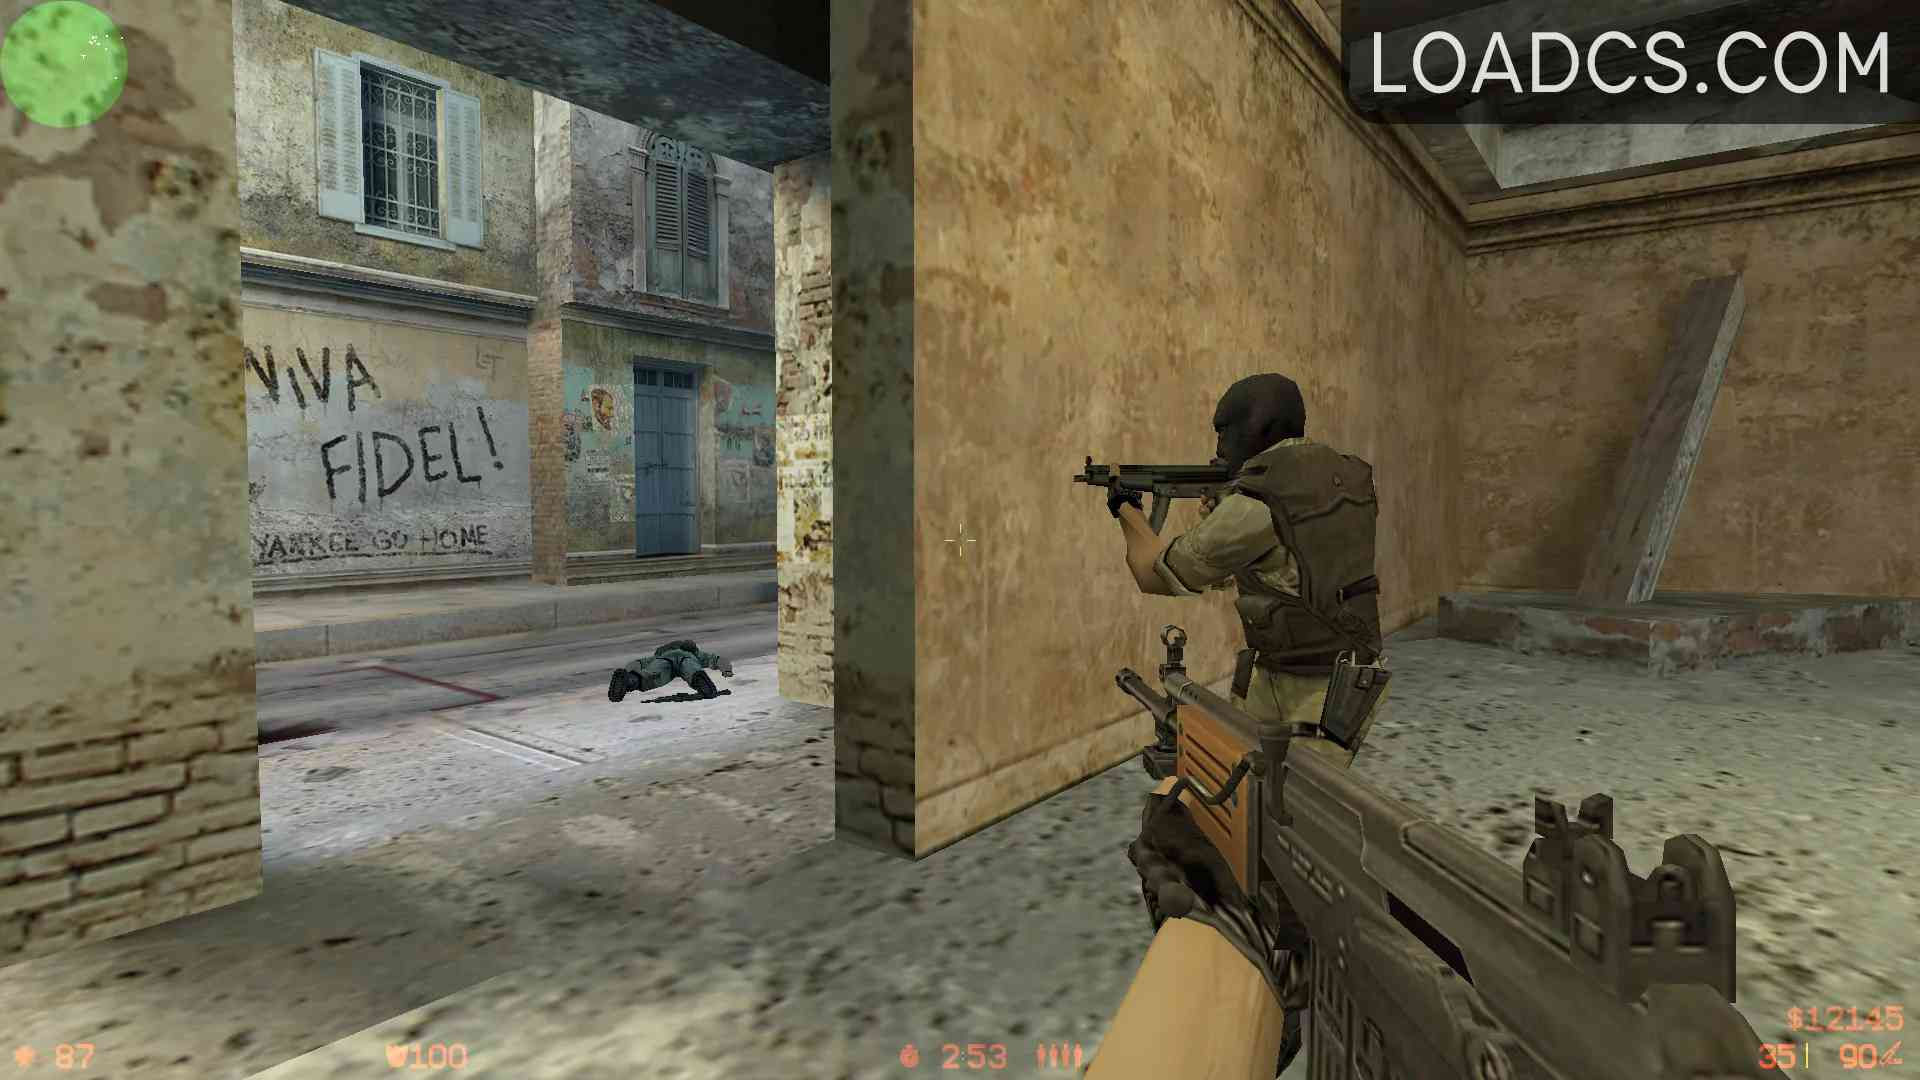

In [200]:
messages = [
       {
            "role": "system",
            "content": f"""Locate the nearest standing person from counterstrike gameplay. Locate the exact location of the middle of the body. Output JSON containing the point.
            Example:
            
            Q: <provided game play image>
            A: {example2_response}"""
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_string}"
                    }
                },
            ]
        }
    ]

messages